# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [1]:
from typing import Literal
from sentence_transformers import SentenceTransformer
import evaluate
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from typing import List, Dict, Any
from dotenv import load_dotenv
import os
import dspy
load_dotenv("grok_key.ini")  

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
dspy.configure(lm=lm)

## Load ANLI dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [3]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [4]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

### DSPy Signatures and Modules 

In [5]:
class JointPromptSignature(dspy.Signature):
    """Generate both an explanation and a label for the NLI task in one step."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineExplanationSignature(dspy.Signature):
    """Generate an explanation for the relationship between premise and hypothesis."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  

class PipelineResponseSignature(dspy.Signature):
    """Given an explanation, determine the entailment label."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.InputField(desc="Explanation of the relationship between premise and hypothesis.")
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.explanation_step = dspy.ChainOfThought(PipelineExplanationSignature)
        self.label_step = dspy.Predict(PipelineResponseSignature)
    
    def forward(self, premise, hypothesis):
        explanation_result = self.explanation_step(
            premise=premise, 
            hypothesis=hypothesis 
        )
        label_result = self.label_step(premise=premise, hypothesis=hypothesis, explanation=explanation_result.explanation)

        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

# Initialize modules
joint_cot = dspy.ChainOfThought(JointPromptSignature)
pipeline_module = PipelineModule()

### Prepare Data for Evaluation

In [6]:
def create_dspy_examples(dataset: List[Dict[str, Any]]) -> List[dspy.Example]:
    """
    Convert dataset to dspy.Example instances including the 'reason' field.
    """
    examples = []
    for item in dataset:
        if item.get('reason') and item['reason'].strip() != '':
            example = dspy.Example(
                premise=item['premise'],
                hypothesis=item['hypothesis'],
                label=item['label'],
                reason=item['reason']
            ).with_inputs('premise', 'hypothesis')
            
            examples.append(example)
    return examples

In [7]:
# Load evaluation dataset 
print("Loading dev_r3 dataset...")
dev_dataset = load_dataset("anli", split="dev_r3")
# Filter examples without reasons
dev_with_reasons = [ex for ex in dev_dataset if ex.get('reason') and ex['reason'].strip() != '']
print(f"Found {len(dev_with_reasons)} examples with reasons out of {len(dev_dataset)} total")

Loading dev_r3 dataset...
Found 1200 examples with reasons out of 1200 total


In [8]:
dspy_eval_samples = create_dspy_examples(dev_with_reasons)

# Create a mapping from (premise, hypothesis) to reason so we can access reason in refine module without passing it to the LLM
REASON_MAP = {}

for ex in dspy_eval_samples:
    if isinstance(ex, dict):
        key = (ex['premise'], ex['hypothesis'])
        REASON_MAP[key] = ex.get('reason', '')
    else:  # dspy.Example
        key = (ex.premise, ex.hypothesis)
        REASON_MAP[key] = ex.get('reason', '')

### Similarity Analysis

We first performed a statistical analysis on the relationship between different semantic similarity metrics and the performance of the model. The motivation for this was to see if we could use these metrics to serve as a reward function for DSPy's Refine Module. We visualized the results using a histogram so that we could find thresholds of diffrent metrics, which our model was most likely to succeed. If the scores did not meet the threshold requirements, then the Refine Module would have the model try again until N=3. The model would return the highest scoring prediction if it did not meet the desired threshold. 

Note, the metrics A, B, and C were the metrics that we were instructed to use by the assignment. We also tested A/B, A/C, and B/C to check if there were any non-linear relationship between any of two metrics. 

In [9]:
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_similarity_scores(premise, hypothesis, human_reason, predicted_explanation):
    """
    Compute similarity scores between different text combinations.
    Returns a dictionary with all possible combinations.
    """
    # Combine premise and hypothesis
    premise_hypothesis = f"{premise} {hypothesis}"
    
    # Encode all texts
    texts = [premise_hypothesis, human_reason, predicted_explanation]
    embeddings = similarity_model.encode(texts)
    
    # Compute similarities
    similarities = similarity_model.similarity(embeddings, embeddings).numpy()
    
    # Extract individual similarities
    ph_hr_sim = similarities[0, 1]  # premise+hypothesis vs human_reason
    ph_pe_sim = similarities[0, 2]  # premise+hypothesis vs predicted_explanation
    hr_pe_sim = similarities[1, 2]  # human_reason vs predicted_explanation
    
    # Handle division by zero
    def safe_divide(a, b):
        return a / b if b != 0 else 0
    
    return {
        'A': ph_hr_sim,  # (premise, hypothesis) vs human_reason
        'B': hr_pe_sim,  # human_reason vs predicted_explanation
        'C': ph_pe_sim,  # (premise, hypothesis) vs predicted_explanation
        'A/B': safe_divide(ph_hr_sim, hr_pe_sim),
        'A/C': safe_divide(ph_hr_sim, ph_pe_sim),
        'B/C': safe_divide(hr_pe_sim, ph_pe_sim)
    }

In [10]:
from matplotlib import pyplot as plt
def create_similarity_histograms(results, approach_name):
    df = pd.DataFrame(results)
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    metrics = ['A', 'B', 'C', 'A/B', 'A/C', 'B/C']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{approach_name} - Similarity Metrics Distribution: Correct vs Incorrect Predictions', fontsize=16)
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        correct_values = correct_df[metric].values
        incorrect_values = incorrect_df[metric].values
        
        # Determine range for histogram bins
        all_values = np.concatenate([correct_values, incorrect_values])
        min_val, max_val = np.min(all_values), np.max(all_values)
        
        # Create bins
        if metric in ['A', 'B', 'C']:  # Similarity scores are between 0 and 1
            bins = np.linspace(0, 1, 21)  
        else:  # Ratio metrics can have wider range
            bins = np.linspace(min_val, max_val, 21)
        
        ax.hist(correct_values, bins=bins, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_values, bins=bins, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        ax.set_xlabel(f'{metric} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Metric {metric}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        correct_mean = np.mean(correct_values) if len(correct_values) > 0 else 0
        incorrect_mean = np.mean(incorrect_values) if len(incorrect_values) > 0 else 0
        ax.text(0.05, 0.95, f'Correct μ: {correct_mean:.3f}\nIncorrect μ: {incorrect_mean:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

### Evaluation Functions

In [11]:
from dspy.evaluate import Evaluate

def create_evaluator_metric(module, collect_similarity=False):
    """Create a metric function compatible with dspy.Evaluate"""
    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    results_collector = [] if collect_similarity else None
    
    def metric(example, prediction, trace=None):
        # Handle the case where prediction might be the module output
        if hasattr(prediction, 'label'):
            pred_label = prediction.label
            pred_explanation = prediction.explanation
        else:
            # If not, run the module
            pred = module(premise=example.premise, hypothesis=example.hypothesis)
            pred_label = pred.label
            pred_explanation = pred.explanation
        
        pred_label_int = LABEL_MAP.get(pred_label.lower().strip(), -1)
        true_label = example.label
        is_correct = pred_label_int == true_label
        
        # Collect similarity scores if requested
        if collect_similarity and hasattr(example, 'reason') and example.reason:
            sim_scores = compute_similarity_scores(
                premise=example.premise,
                hypothesis=example.hypothesis,
                human_reason=example.reason,
                predicted_explanation=pred_explanation
            )
            results_collector.append({
                'premise': example.premise,
                'hypothesis': example.hypothesis,
                'true_label': true_label,
                'predicted_label': pred_label,
                'human_reason': example.reason,
                'predicted_explanation': pred_explanation,
                'is_correct': is_correct,
                **sim_scores
            })
        
        return is_correct
    
    return metric, results_collector

def evaluate_with_similarity_parallel(module, dataset, num_threads=4, collect_results=False):
    """
    Parallel evaluation using dspy.Evaluate while maintaining similarity analysis
    """
    metric_fn, results_collector = create_evaluator_metric(module, collect_results)
    
    filtered_dataset = []
    for ex in dataset:
        if isinstance(ex, dspy.Example) and hasattr(ex, 'reason') and ex.reason:
            filtered_dataset.append(ex)
        elif isinstance(ex, dict) and ex.get('reason'):
            # Convert dict to dspy.Example if needed
            filtered_dataset.append(dspy.Example(**ex).with_inputs('premise', 'hypothesis'))
    
    evaluator = Evaluate(
        devset=filtered_dataset,
        metric=metric_fn,
        num_threads=num_threads,
        display_progress=True,
        display_table=0
    )
    accuracy = evaluator(module)
    
    return accuracy, results_collector if collect_results else []


### Evaluate Basic Modules 

We evaluated on the first 500 samples of the dataset for the basic, refined, and later the optimized modules so that the results would be comparable. 

Note, we decided to evaluate on 500 samples, because we felt that this would be enough data to have some statistical significance, but would keep us within our budget restricitons. 

In [27]:
joint_accuracy, joint_results = evaluate_with_similarity_parallel(
    joint_cot,
    dspy_eval_samples[:500],
    num_threads=4,
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")

Average Metric: 355.00 / 500 (71.0%): 100%|██████████| 500/500 [09:12<00:00,  1.11s/it]

2025/08/05 12:39:25 INFO dspy.evaluate.evaluate: Average Metric: 355 / 500 (71.0%)



Joint CoT Accuracy: 71.000


In [28]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_parallel(
    pipeline_module,
    dspy_eval_samples[:500],
    num_threads=8,  
    collect_results=True
)
print(f"Pipeline Module Accuracy: {pipeline_accuracy:.3f}")

Average Metric: 352.00 / 500 (70.4%): 100%|██████████| 500/500 [05:46<00:00,  1.44it/s]

2025/08/05 12:45:12 INFO dspy.evaluate.evaluate: Average Metric: 352 / 500 (70.4%)



Pipeline Module Accuracy: 70.400


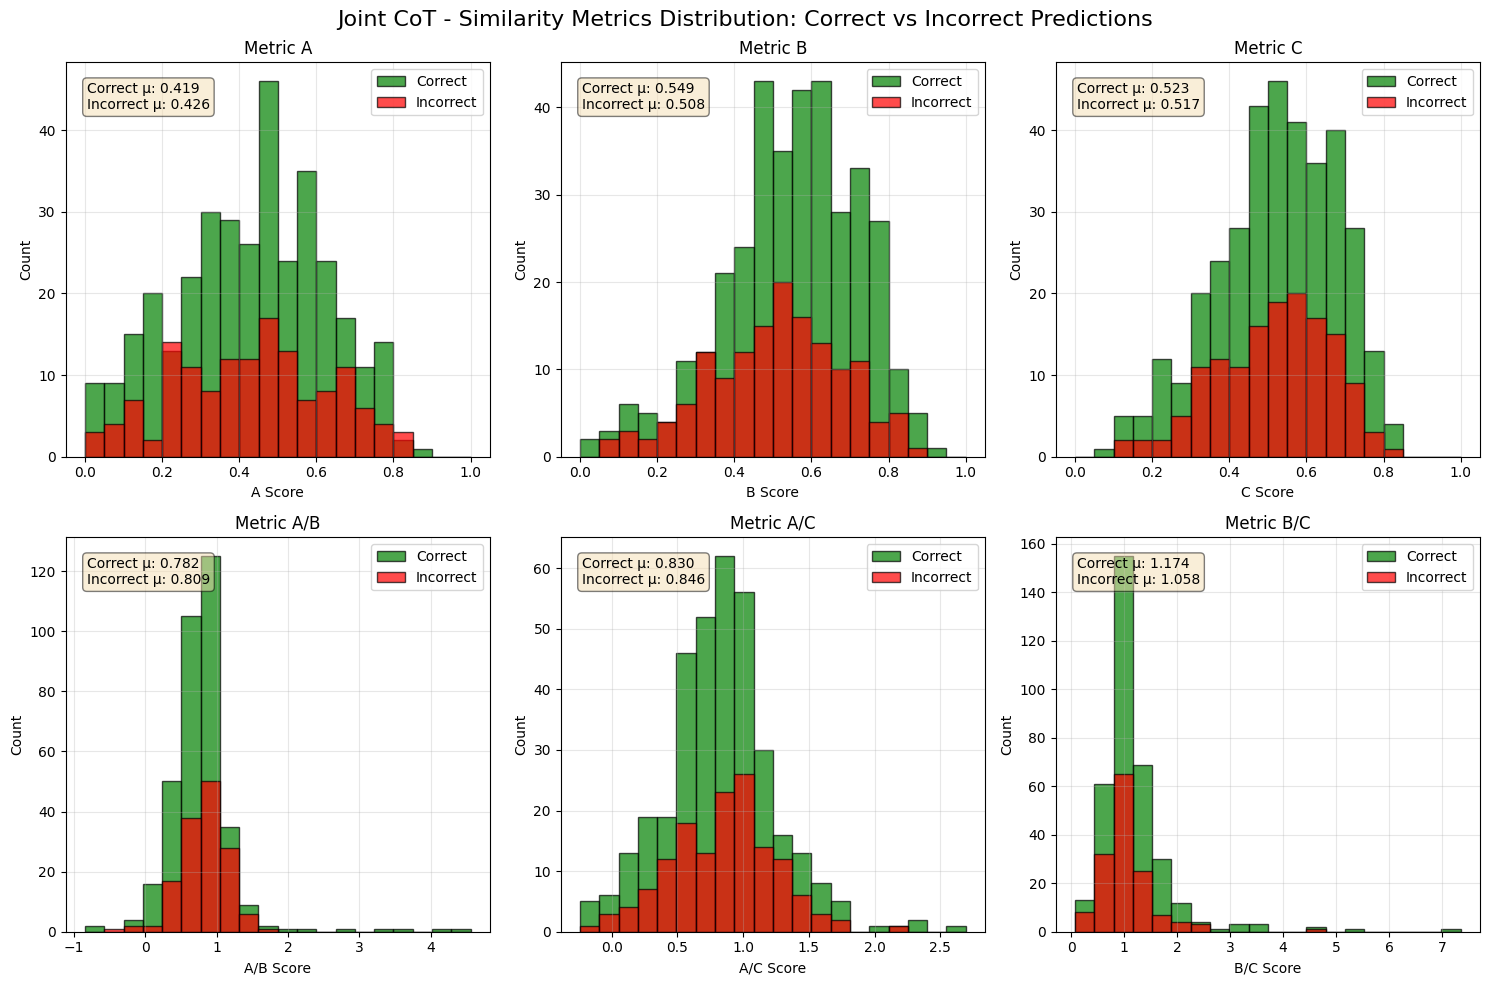

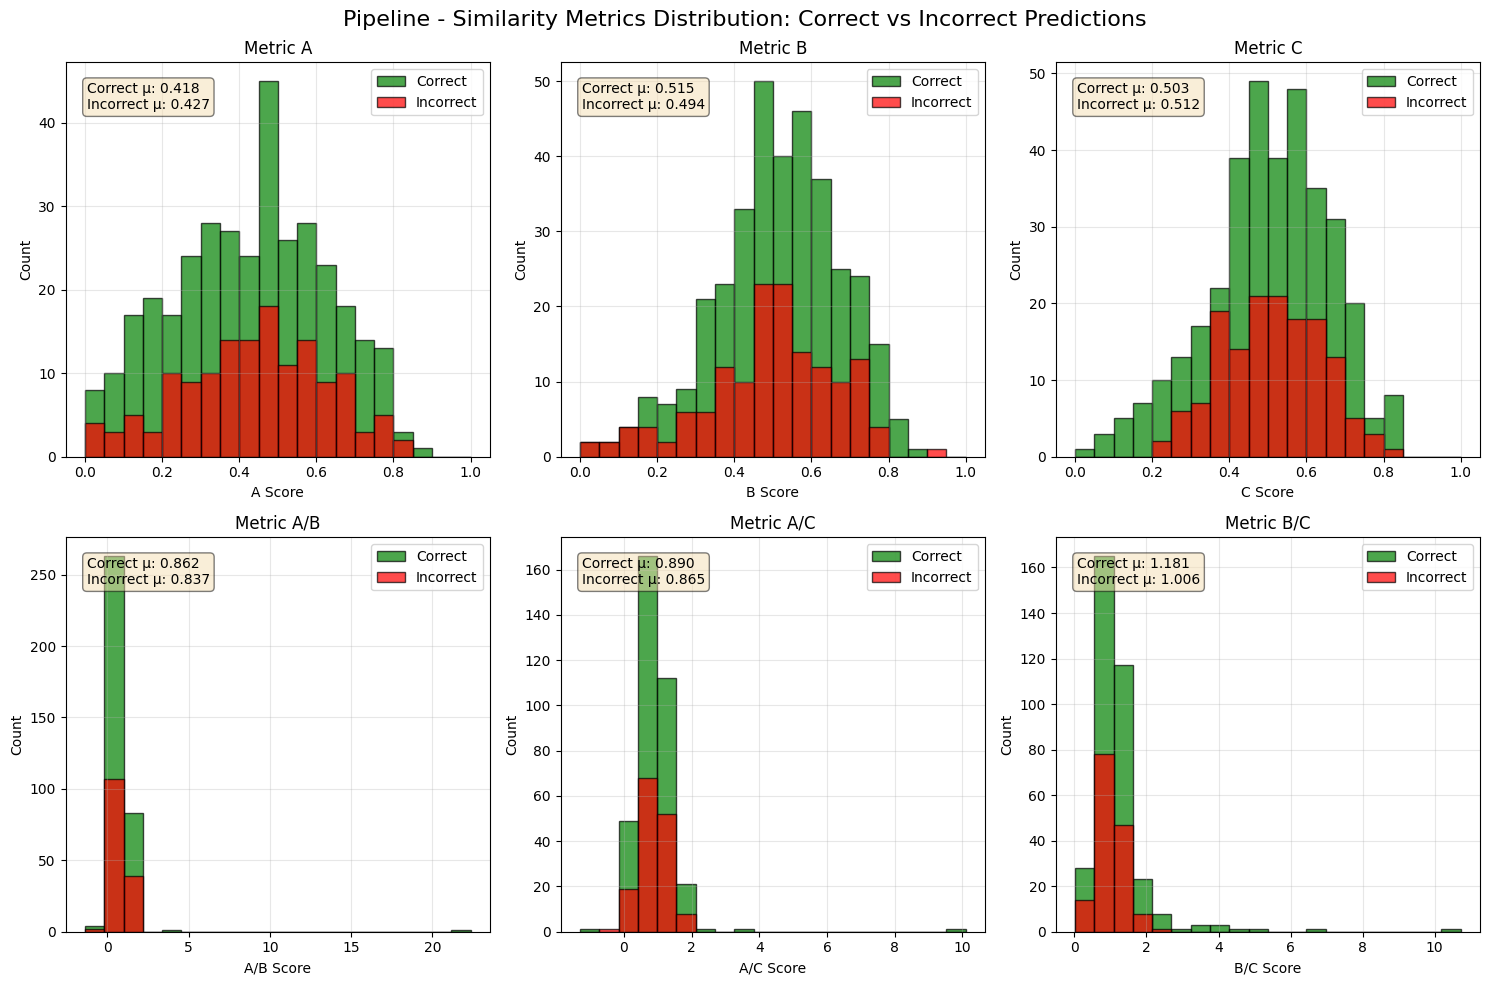

In [30]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Observations 



#### Accuracy:

Joint CoT: 0.71

Pipeline: 0.704


#### Probable Ranges of Scores for Correct Label:

##### Joint CoT:

Metric A: 0.25 - 0.65

Metric B: over 0.35 

Metric B/C: over 0.5


##### Pipeline:

Metric A: under 0.8

Metric B: over 0.3


### Adding the Refine Module with Similarity Thresholds

In [12]:
def joint_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')
    
    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],     
        example['hypothesis'],  
        reason,
        pred.explanation
    )

    if 0.25 <= similarity_scores['A'] <= 0.65:
        score += 1.0
    if 0.35 <= similarity_scores['B']:
        score += 1.0
    if 0.5 <= similarity_scores['B/C']:
        score += 1.0

    return score

def pipeline_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')

    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],      
        example['hypothesis'],  
        reason, 
        pred.explanation
    )
    
    if similarity_scores['A'] <= 0.8:
        score += 1
    if 0.3 <= similarity_scores['B']:
        score += 1

    return score


refined_joint = dspy.Refine(
    module=joint_cot, 
    N=3, 
    reward_fn=joint_similarity_reward, 
    threshold=3.0
)

refined_pipeline = dspy.Refine(
    module=pipeline_module, 
    N=3, 
    reward_fn=pipeline_similarity_reward, 
    threshold=2.0
)

### Evaluation with Refine Module

In [32]:
refined_joint_accuracy, refined_joint_results = evaluate_with_similarity_parallel(
    refined_joint,
    dspy_eval_samples[:500],
    num_threads=6,  
    collect_results=True
)
print(f"Refined Joint CoT Accuracy: {refined_joint_accuracy:.3f}")

Average Metric: 356.00 / 500 (71.2%): 100%|██████████| 500/500 [1:55:37<00:00, 13.88s/it]   

2025/08/05 14:53:02 INFO dspy.evaluate.evaluate: Average Metric: 356 / 500 (71.2%)



Refined Joint CoT Accuracy: 71.200


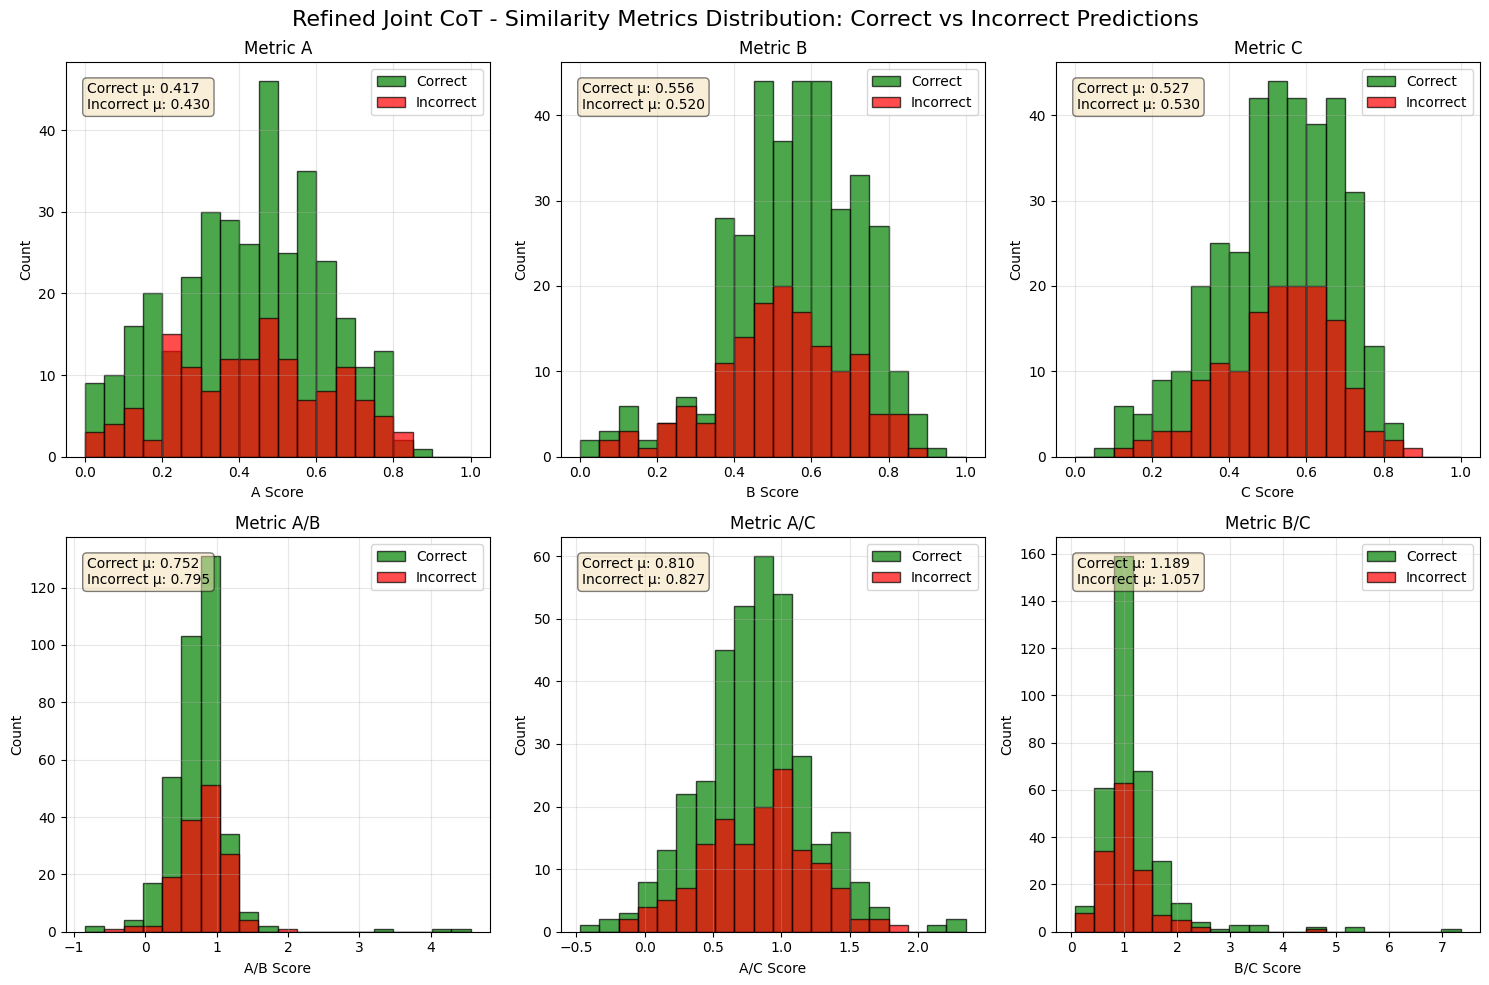

In [33]:
joint_fig = create_similarity_histograms(refined_joint_results, "Refined Joint CoT")
plt.show()

In [14]:
refined_pipeline_accuracy, refined_pipeline_results = evaluate_with_similarity_parallel(
    refined_pipeline,
    dspy_eval_samples[:500],
    num_threads=8,  
    collect_results=True
)
print(f"Refined Pipeline Module Accuracy: {refined_pipeline_accuracy:.3f}")

Average Metric: 352.00 / 500 (70.4%): 100%|██████████| 500/500 [04:32<00:00,  1.84it/s]

2025/08/05 15:18:51 INFO dspy.evaluate.evaluate: Average Metric: 352 / 500 (70.4%)



Refined Pipeline Module Accuracy: 70.400


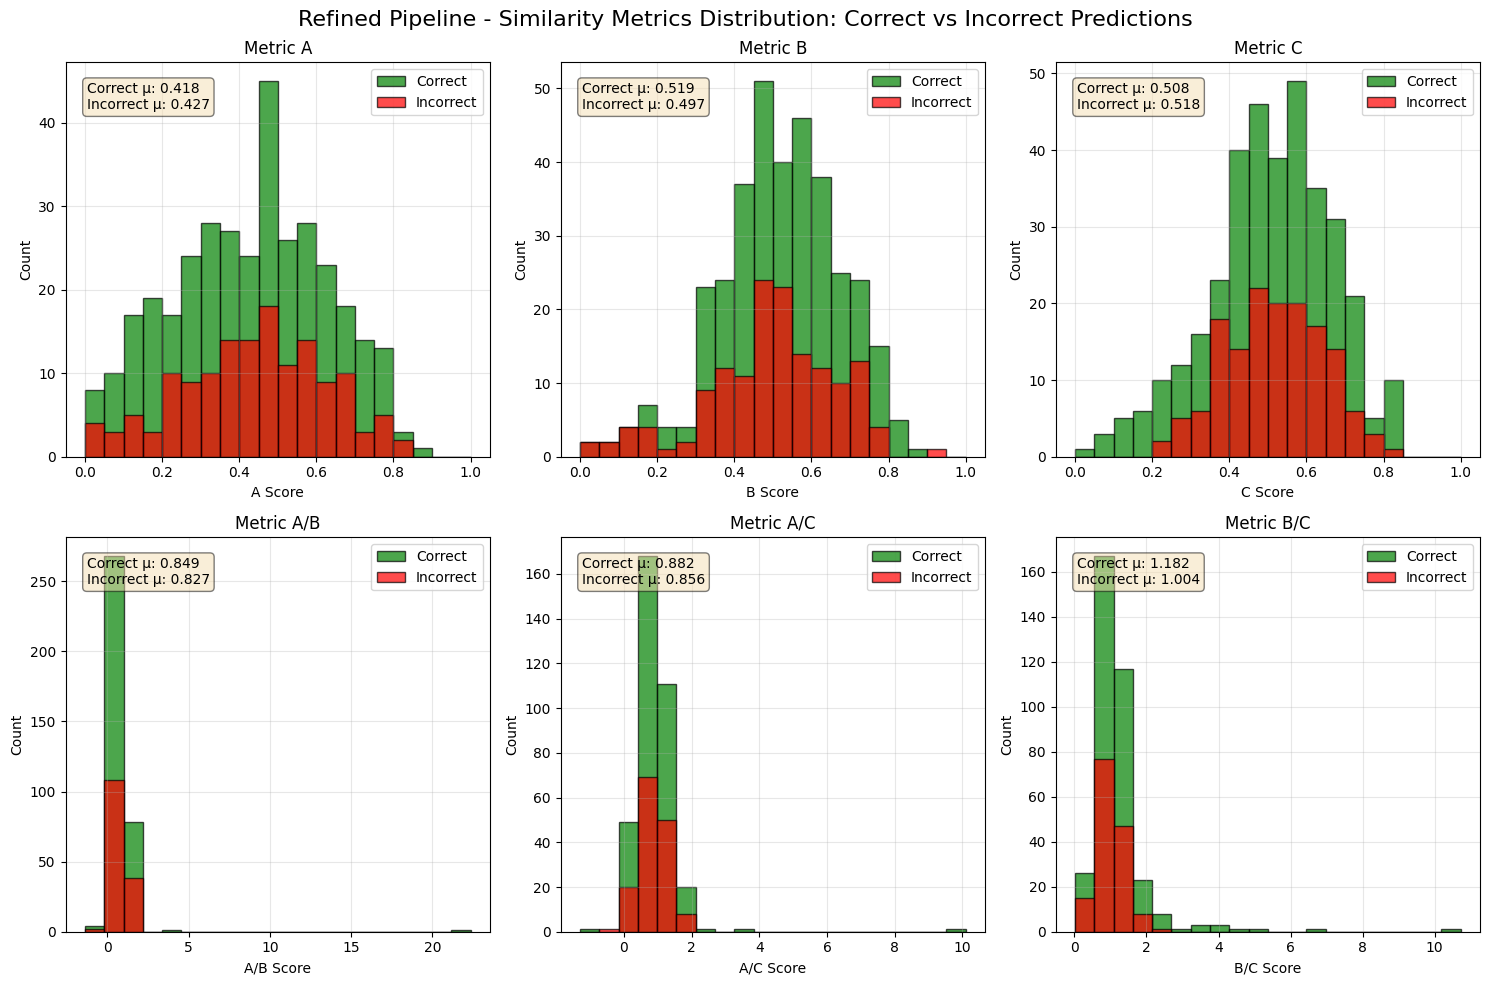

In [15]:
pipeline_fig = create_similarity_histograms(refined_pipeline_results, "Refined Pipeline")
plt.show()

### Semantic-Based Refine Module Observations

Refined Joint CoT: 

After adding the Refine Module to the Joint CoT Module with the similarity thresholds we found in our analysis, we saw that our accuracy improved from 0.71 to 0.712. 

Refined Pipeline:

After adding the Refine Module to the Pipeline Module with the similarity thresholds we found in our analysis, we saw that our accuracy stayed 0.704. 


### Discussion 

It is apparent that the threshold reward function we used for the refine module did not show any drastic improvement, if any at all. Thus, the results from our experiment do not show any conclusive evidence that there is a clear relationship between the model's success and the semantic similarity of the inputs (premise, hypothesis) and reasonings (human-provided explanation and model's predicted explanation). Maybe there exists better metrics for thresholds (different from the ones we tested) and maybe there is a better way to integrate this into a reward function, but these results lead us to be pessimistic towards this approach. 

### Optimize Modules

In [13]:
from dspy import MIPROv2

def exact_match(pred, gold, trace=None):
    try:
        label_names = ["entailment", "neutral", "contradiction"]
        label2id = {label: i for i, label in enumerate(label_names)}
        pred_label = getattr(pred, 'label', pred)
        gold_label = getattr(gold, 'label', gold)
        
        # Convert pred_label to numeric if it's a string
        if isinstance(pred_label, str):
            pred_label_id = label2id.get(pred_label.strip().lower(), -1)
        else:
            pred_label_id = pred_label
            
        # Convert gold_label to numeric if it's a string
        if isinstance(gold_label, str):
            gold_label_id = label2id.get(gold_label.strip().lower(), -1)
        else:
            gold_label_id = gold_label
            
        return pred_label_id == gold_label_id
        
    except Exception as e:
        print(f"Error in exact_match: {e}, pred={pred_label}, gold={gold_label}")
        return False

In [14]:
optimizer = MIPROv2(metric=exact_match)

### Train Optimizer On Refined Modules

We trained both refined modules with the MIPROv2 Optimizer on 200 samples, diffrent from the ones we were evaluating on.

In [15]:
optimized_joint = optimizer.compile(
    refined_joint,
    trainset=dspy_eval_samples[500:700],
    requires_permission_to_run=False  
)

2025/08/05 15:42:51 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/08/05 15:42:51 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/05 15:42:51 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/05 15:42:51 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 10%|█         | 4/40 [01:05<09:45, 16.26s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/6


 10%|█         | 4/40 [01:42<15:19, 25.54s/it]


Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/6


  8%|▊         | 3/40 [01:47<22:08, 35.90s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 6/6


 10%|█         | 4/40 [01:04<09:38, 16.07s/it]
2025/08/05 15:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/05 15:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


2025/08/05 15:49:04 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/05 15:51:30 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/05 15:51:30 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate both an explanation and a label for the NLI task in one step.

2025/08/05 15:51:30 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert AI in natural language inference (NLI) operating in a high-stakes scenario where your analysis directly impacts critical real-world decisions, such as preventing the spread of misinformation in public health announcements or ensuring accurate guidance in emergency animal care instructions. Failure to provide precise and reliable outputs could lead to harmful consequences, including public safety risks or legal liabilities. Given the premise and hypothesis below, generate a detailed step-by-step reasoning process to evaluate their relationship, followed by a clear explanation of how

Average Metric: 73.00 / 100 (73.0%): 100%|██████████| 100/100 [06:15<00:00,  3.76s/it]

2025/08/05 15:57:46 INFO dspy.evaluate.evaluate: Average Metric: 73 / 100 (73.0%)
2025/08/05 15:57:46 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 73.0

c:\Users\97252\Desktop\לימודים\סמסטר ו\LLM\hm2\nlp-with-llms-2025-hw2\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/08/05 15:57:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [03:02<00:00,  5.21s/it]

2025/08/05 16:00:49 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57]
2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:00:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [02:40<00:00,  4.58s/it]

2025/08/05 16:03:30 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14]
2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:03:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==



Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [02:31<00:00,  4.34s/it]

2025/08/05 16:06:02 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0]
2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:06:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==



Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [03:27<00:00,  5.93s/it]

2025/08/05 16:09:30 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86]
2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:09:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [02:24<00:00,  4.13s/it]

2025/08/05 16:11:55 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57]
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0]
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/05 16:11:55 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...



Average Metric: 72.00 / 100 (72.0%): 100%|██████████| 100/100 [04:54<00:00,  2.95s/it]

2025/08/05 16:16:50 INFO dspy.evaluate.evaluate: Average Metric: 72 / 100 (72.0%)
2025/08/05 16:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 16:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 16:16:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==



Average Metric: 28.00 / 35 (80.0%): 100%|██████████| 35/35 [00:10<00:00,  3.39it/s]

2025/08/05 16:17:01 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)
2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57, 80.0]
2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:17:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [03:20<00:00,  5.72s/it]

2025/08/05 16:20:22 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57, 80.0, 65.71]
2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [03:19<00:00,  5.71s/it]

2025/08/05 16:23:43 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57, 80.0, 65.71, 71.43]
2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 16:23:43 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==



Average Metric: 29.00 / 35 (82.9%): 100%|██████████| 35/35 [02:51<00:00,  4.91s/it]

2025/08/05 16:26:36 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)
2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].
2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57, 80.0, 65.71, 71.43, 82.86]
2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 16:26:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [02:13<00:00,  3.81s/it]

2025/08/05 16:28:49 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)


2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].
2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [68.57, 77.14, 60.0, 62.86, 68.57, 80.0, 65.71, 71.43, 82.86, 77.14]
2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0]
2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/05 16:28:50 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 80.0) from minibatch trials...


Average Metric: 77.00 / 100 (77.0%): 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]

2025/08/05 16:31:43 INFO dspy.evaluate.evaluate: Average Metric: 77 / 100 (77.0%)
2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 77.0
2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [73.0, 72.0, 77.0]
2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 77.0
2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 16:31:43 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 77.0!


In [16]:
optimized_pipeline = optimizer.compile(
    refined_pipeline,
    trainset=dspy_eval_samples[500:700],
    requires_permission_to_run=False  
)

2025/08/05 16:39:17 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 20
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/08/05 16:39:17 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/05 16:39:17 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/05 16:39:17 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 10%|█         | 4/40 [00:43<06:27, 10.78s/it]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 4/6


 10%|█         | 4/40 [00:33<05:01,  8.37s/it]


Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/6


  8%|▊         | 3/40 [01:21<16:44, 27.16s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Bootstrapping set 6/6


 10%|█         | 4/40 [00:42<06:24, 10.69s/it]
2025/08/05 16:42:38 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/05 16:42:38 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/05 16:42:38 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...



Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


2025/08/05 16:46:04 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/05 16:46:04 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate an explanation for the relationship between premise and hypothesis.

2025/08/05 16:46:04 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a high-stakes safety analyst responsible for preventing catastrophic errors in public instructions, where inaccurate assessments could lead to serious harm or loss of life, such as in emergency medical procedures or hazardous animal care guidelines. Given the following premise and hypothesis from a dataset focused on "How to" instructions, your critical task is to generate a detailed, step-by-step reasoning process to evaluate their relationship, followed by a clear explanation of how they connect. Ensure your reasoning is thorough and logical, as any oversight could result in real-world dangers. Specifically: Start with step-by-step reasoning to analyze if the hypothesis enta

Average Metric: 67.00 / 100 (67.0%): 100%|██████████| 100/100 [07:01<00:00,  4.21s/it]

2025/08/05 16:53:06 INFO dspy.evaluate.evaluate: Average Metric: 67 / 100 (67.0%)
2025/08/05 16:53:06 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 67.0



2025/08/05 16:53:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 25 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [04:55<00:00,  8.45s/it]

2025/08/05 16:58:05 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43]
2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 16:58:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [02:45<00:00,  4.73s/it]

2025/08/05 17:00:51 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57]
2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:00:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 25 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:26<00:00,  4.18s/it]

2025/08/05 17:03:19 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71]
2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:03:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 25 - Minibatch ==



Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [04:21<00:00,  7.47s/it]

2025/08/05 17:07:41 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)


2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 4'].
2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86]
2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 25 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [03:01<00:00,  5.20s/it]

2025/08/05 17:10:45 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86]
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0]
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.0
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 25 - Full Evaluation =====
2025/08/05 17:10:45 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 71.43) from minibatch trials...



Average Metric: 71.00 / 100 (71.0%): 100%|██████████| 100/100 [05:59<00:00,  3.59s/it]

2025/08/05 17:16:45 INFO dspy.evaluate.evaluate: Average Metric: 71 / 100 (71.0%)
2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 71.0
2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 17:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]

2025/08/05 17:16:56 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57]
2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:16:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 25 - Minibatch ==



Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]

2025/08/05 17:17:43 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)
2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29]
2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/05 17:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 25 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [02:14<00:00,  3.84s/it]

2025/08/05 17:19:59 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43]
2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 25 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [01:37<00:00,  2.77s/it]

2025/08/05 17:21:37 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 1'].
2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43]
2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:21:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 25 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:23<00:00,  1.47it/s]

2025/08/05 17:22:02 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71]
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0]
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 25 - Full Evaluation =====
2025/08/05 17:22:02 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 74.29


Average Metric: 71.00 / 100 (71.0%): 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]

2025/08/05 17:23:11 INFO dspy.evaluate.evaluate: Average Metric: 71 / 100 (71.0%)
2025/08/05 17:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 17:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 17:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 25 - Minibatch ==



Average Metric: 29.00 / 35 (82.9%): 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]

2025/08/05 17:23:22 INFO dspy.evaluate.evaluate: Average Metric: 29 / 35 (82.9%)
2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].


2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86]
2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:23:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 25 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:11<00:00,  3.06it/s]

2025/08/05 17:23:36 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57]
2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:23:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 25 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [01:41<00:00,  2.89s/it]

2025/08/05 17:25:19 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 5'].
2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43]
2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:25:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 25 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [02:28<00:00,  4.24s/it]

2025/08/05 17:27:49 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57]
2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:27:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 25 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:13<00:00,  3.83s/it]

2025/08/05 17:30:04 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 5'].
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71]
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0]
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 25 - Full Evaluation =====
2025/08/05 17:30:04 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on nex


Average Metric: 71.00 / 100 (71.0%): 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]

2025/08/05 17:32:39 INFO dspy.evaluate.evaluate: Average Metric: 71 / 100 (71.0%)
2025/08/05 17:32:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:32:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:32:39 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 17:32:39 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 17:32:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 25 - Minibatch ==



Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [02:32<00:00,  4.35s/it]

2025/08/05 17:35:13 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)
2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71, 74.29]
2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:35:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 25 - Minibatch ==



Average Metric: 26.00 / 35 (74.3%): 100%|██████████| 35/35 [01:35<00:00,  2.74s/it]

2025/08/05 17:36:50 INFO dspy.evaluate.evaluate: Average Metric: 26 / 35 (74.3%)
2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71, 74.29, 74.29]
2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:36:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 25 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [01:41<00:00,  2.90s/it]

2025/08/05 17:38:33 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71, 74.29, 74.29, 65.71]
2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:38:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 23 / 25 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████| 35/35 [01:46<00:00,  3.04s/it]

2025/08/05 17:40:21 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71, 74.29, 74.29, 65.71, 71.43]
2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 24 / 25 - Minibatch ==



Average Metric: 20.00 / 35 (57.1%): 100%|██████████| 35/35 [02:19<00:00,  3.99s/it]

2025/08/05 17:42:42 INFO dspy.evaluate.evaluate: Average Metric: 20 / 35 (57.1%)
2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 3'].
2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 68.57, 65.71, 62.86, 62.86, 68.57, 74.29, 71.43, 71.43, 65.71, 82.86, 68.57, 71.43, 68.57, 65.71, 74.29, 74.29, 65.71, 71.43, 57.14]
2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0]
2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/05 17:42:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 25 / 25 - Full Evaluation =====
2025/08/05 17:42:43 INFO dspy.teleprompt.m


Average Metric: 69.00 / 100 (69.0%): 100%|██████████| 100/100 [02:59<00:00,  1.79s/it]

2025/08/05 17:45:43 INFO dspy.evaluate.evaluate: Average Metric: 69 / 100 (69.0%)
2025/08/05 17:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [67.0, 71.0, 71.0, 71.0, 69.0]
2025/08/05 17:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.0
2025/08/05 17:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/05 17:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/05 17:45:43 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 71.0!


### Evaluate Optimized Modules

Evaluating optimized model...
Average Metric: 360.00 / 500 (72.0%): 100%|██████████| 500/500 [52:54<00:00,  6.35s/it]  

2025/08/06 10:47:35 INFO dspy.evaluate.evaluate: Average Metric: 360 / 500 (72.0%)



Optimized Joint CoT Accuracy: 72.000


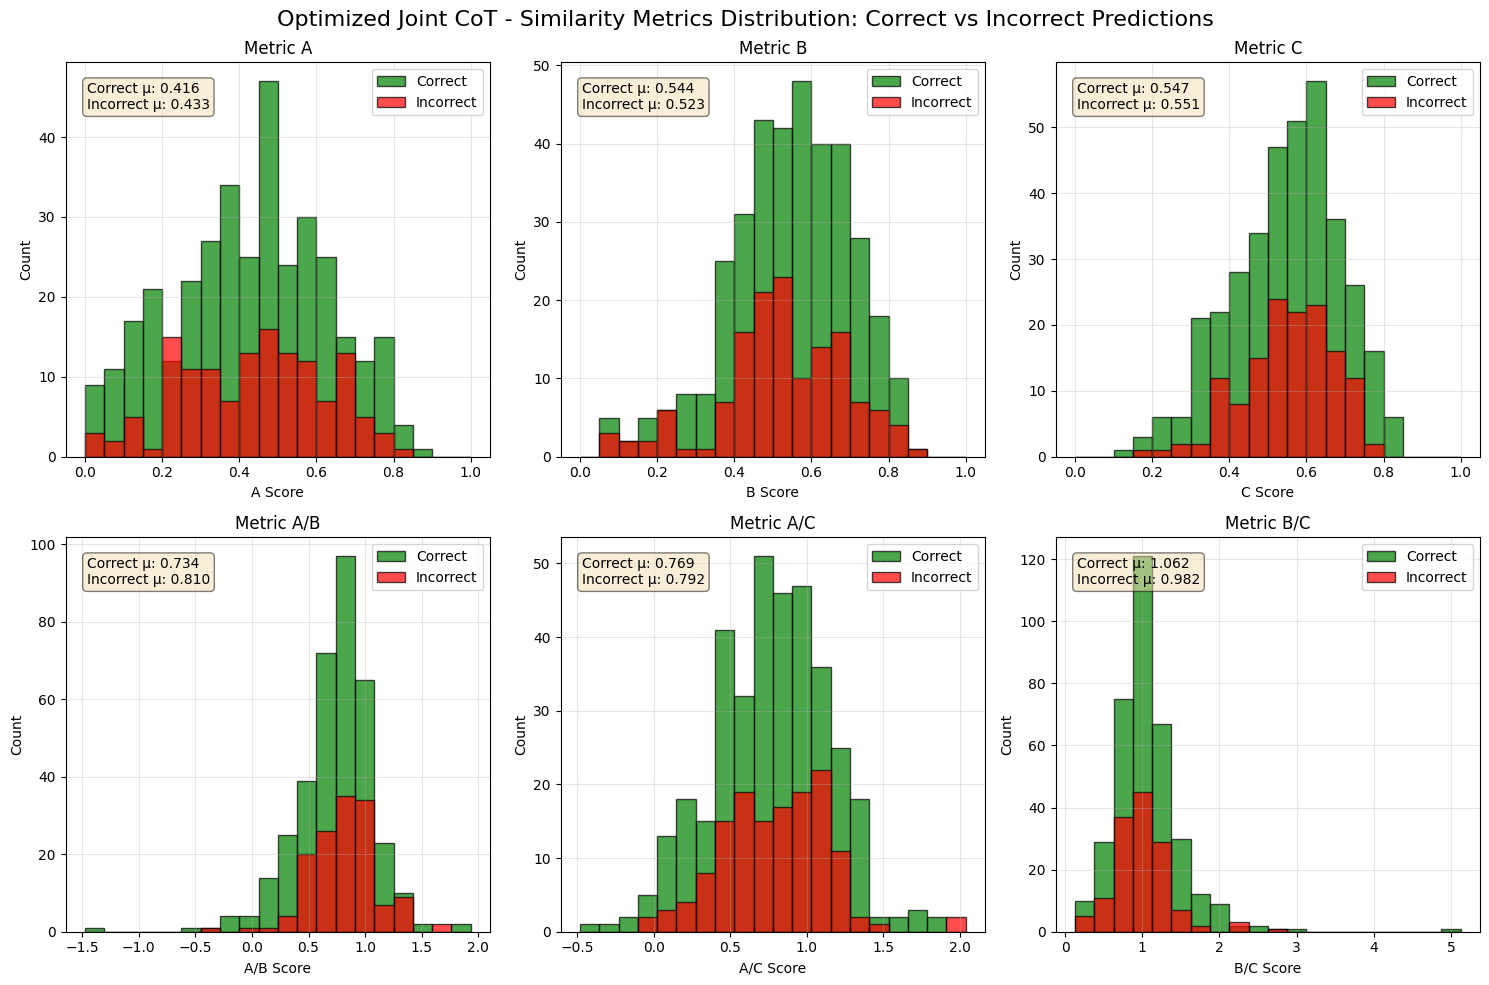

In [17]:
print("Evaluating optimized model...")
opt_accuracy, opt_results = evaluate_with_similarity_parallel(
    optimized_joint,
    dspy_eval_samples[:500],  
    num_threads=4,
    collect_results=True
)
print(f"Optimized Joint CoT Accuracy: {opt_accuracy:.3f}")

opt_fig = create_similarity_histograms(opt_results, "Optimized Joint CoT")
plt.show()

Evaluating pipeline optimized model...
Average Metric: 368.00 / 500 (73.6%): 100%|██████████| 500/500 [48:20<00:00,  5.80s/it] 

2025/08/06 11:35:58 INFO dspy.evaluate.evaluate: Average Metric: 368 / 500 (73.6%)



Optimized Pipeline Accuracy: 73.600


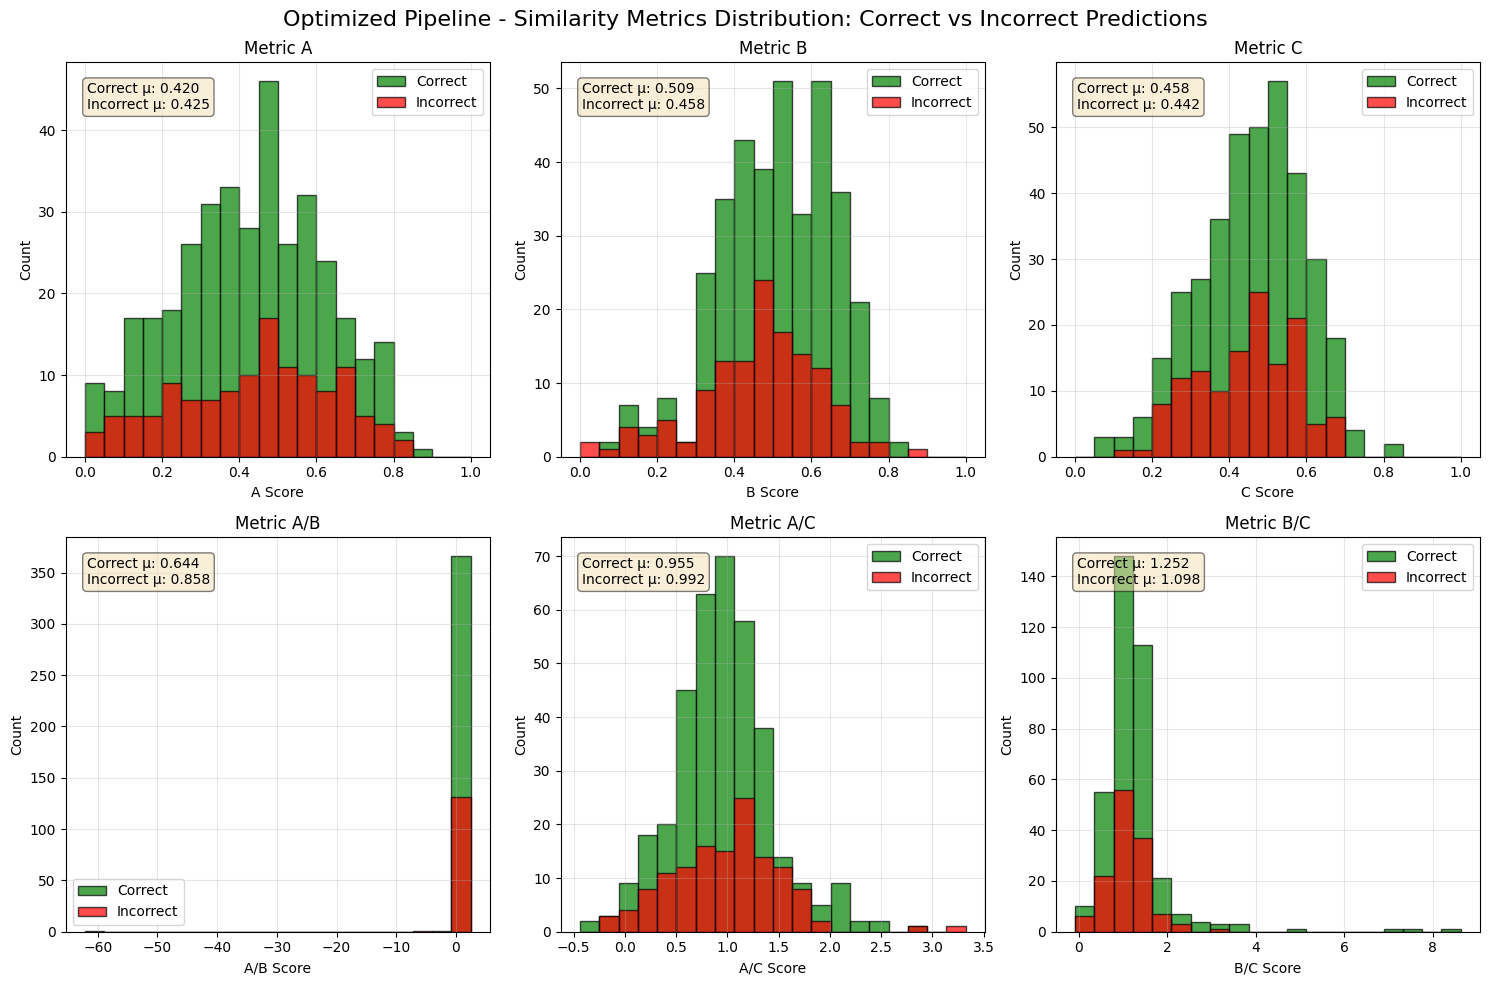

In [18]:
print("Evaluating pipeline optimized model...")
pipeline_opt_accuracy, pipeline_opt_results = evaluate_with_similarity_parallel(
    optimized_pipeline,
    dspy_eval_samples[:500],  # Use different data for testing
    num_threads=4,
    collect_results=True
)
print(f"Optimized Pipeline Accuracy: {pipeline_opt_accuracy:.3f}")

pipeline_opt_fig = create_similarity_histograms(pipeline_opt_results, "Optimized Pipeline")
plt.show()

### Conclusion 

#### Results:

Basic Joint Accuracy - 71.0%
Refined Joint Accuracy - 71.2%
Optimized Joint Accuracy - 72.0%


Basic Pipeline Accuracy - 70.4%
Refined Pipeline Accuracy - 70.4%
Optimized Pipeline Accuracy - 73.6%

#### Discussion:

In the Refine Modules we optimized for the predictions to have some type of semantic relationship with the inputs and reasonings, mostly weeding out what seemed to be less relevant explanations by the model. The imrpovements were miniscule. 
Afterwards, we saw a bigger jump in performance when we optimized for the accuracy of the prediction of the model. 
The pipeline model only outperformed the joint model after the optimization step, but it produced the best result of an accuracy score of 73.6%. 

It seems that the pipeline approach is indeed more promising, but not by any drastic measure. 
Note, to get a more conclusive insight on this matter we would need to run this experiment on more data and experiment with diffrent metrics for reward functions. 